In [ ]:

#import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#drive mounting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Dataset

In [ ]:
#load dataset
df = pd.read_csv('/content/drive/MyDrive/ML_twitter_dataset/twitter.csv',
                 header=None,
                 names=['tweet_record_id', 'entity', 'sentiment', 'tweet_description'])
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (74682, 4)
   tweet_record_id       entity sentiment  \
0             2401  Borderlands  Positive   
1             2401  Borderlands  Positive   
2             2401  Borderlands  Positive   
3             2401  Borderlands  Positive   
4             2401  Borderlands  Positive   

                                   tweet_description  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [ ]:
#keep only the necessary columns
df = df[['sentiment', 'tweet_description']]
print("Data after dropping unwanted columns:")
print(df.head())

Data after dropping unwanted columns:
  sentiment                                  tweet_description
0  Positive  im getting on borderlands and i will murder yo...
1  Positive  I am coming to the borders and I will kill you...
2  Positive  im getting on borderlands and i will kill you ...
3  Positive  im coming on borderlands and i will murder you...
4  Positive  im getting on borderlands 2 and i will murder ...


#Data Cleaning

In [ ]:
#define a function to clean tweet text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    #remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #remove mentions and hashtags (optional)
    text = re.sub(r'\@\w+|\#','', text)
    #remove special characters, numbers and punctuations (keeping only alphabets and spaces)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    #convert to lower case
    text = text.lower()
    #remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#apply cleaning function to tweet_description column
df['clean_tweet'] = df['tweet_description'].apply(clean_text)

print("Cleaned tweets:")
print(df[['tweet_description', 'clean_tweet']].head())



Cleaned tweets:
                                   tweet_description  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                         clean_tweet  
0  im getting on borderlands and i will murder yo...  
1  i am coming to the borders and i will kill you...  
2  im getting on borderlands and i will kill you all  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands and i will murder yo...  


In [ ]:
#drop rows with missing values in key columns
df.dropna(subset=['sentiment', 'clean_tweet'], inplace=True)
print("Data shape after dropping missing values:", df.shape)


Data shape after dropping missing values: (74682, 3)


#Split Data

In [ ]:
#split the dataset into training and testing sets
X = df['clean_tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#display size
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 59745
Test set size: 14937


Vectorization

In [ ]:
#use TF-IDF Vectorizer with stop words removal and bigrams to improve features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.95)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of training vectors (TF-IDF):", X_train_tfidf.shape)
print("Shape of testing vectors (TF-IDF):", X_test_tfidf.shape)


Shape of training vectors (TF-IDF): (59745, 537666)
Shape of testing vectors (TF-IDF): (14937, 537666)


#Apply Cross Validation (GridSearchCV)

In [ ]:
#tune the MultinomialNB hyperparameter (alpha) using GridSearchCV
param_grid = {'alpha': [0.0000000001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best hyperparameter (alpha):", grid.best_params_)
print("Best cross-validation score: {:.4f}".format(grid.best_score_))

Best hyperparameter (alpha): {'alpha': 1e-10}
Best cross-validation score: 0.9081


#Build Model

In [ ]:
#build the final model with the best found parameter and train it
best_nb_model = grid.best_estimator_
best_nb_model.fit(X_train_tfidf, y_train)

#predict on training and testing sets
y_train_pred = best_nb_model.predict(X_train_tfidf)
y_test_pred = best_nb_model.predict(X_test_tfidf)

#evaluate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy: {:.4f}".format(train_accuracy))
print("Testing Accuracy: {:.4f}".format(test_accuracy))
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.9573
Testing Accuracy: 0.9171

Classification Report on Test Data:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.88      0.92      2598
    Negative       0.87      0.96      0.91      4509
     Neutral       0.95      0.90      0.92      3664
    Positive       0.92      0.91      0.92      4166

    accuracy                           0.92     14937
   macro avg       0.93      0.91      0.92     14937
weighted avg       0.92      0.92      0.92     14937



#Confusion Matrix

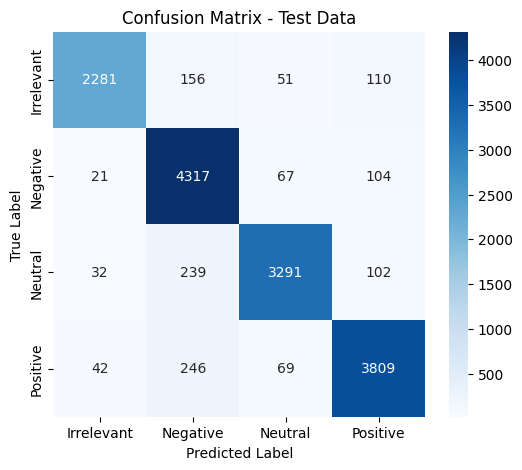

In [ ]:
#plot confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.show()


#Training and Validation Accuracy

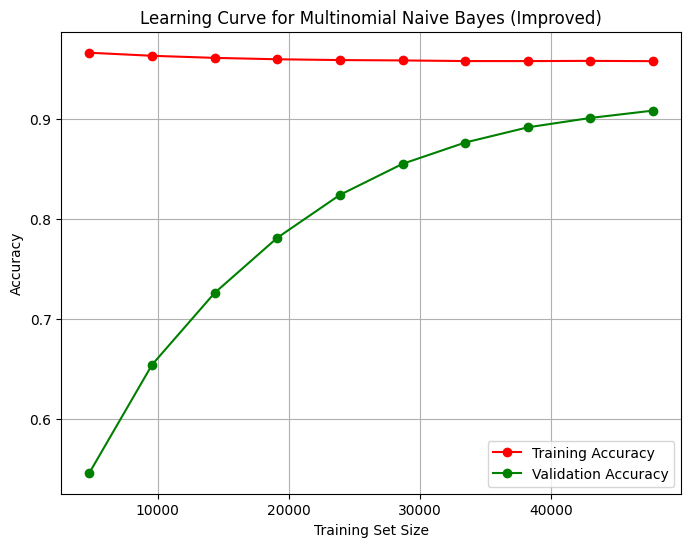

In [145]:
# Plot learning curve for the improved model
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_nb_model,
    X=X_train_tfidf,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training Accuracy")
plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label="Validation Accuracy")
plt.title("Learning Curve for Multinomial Naive Bayes (Improved)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()